In [1]:
#!pip install pandas_datareader -q
#!pip install PyPortfolioOpt -q

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as web
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pypfopt
%load_ext autoreload
%autoreload 2


In [3]:
# https://www.dataroma.com/m/holdings.php?m=BRK BRKA portfolio tracker
start = datetime(2010, 1, 1)
symbols_list = ['AAPL', 'AXP', 'UAA', 'APA', 'SU', 'NFLX', 'XRX','AMZN', 'KO', 'TSLA']

symbols = []
for ticker in symbols_list:
    r = web.DataReader(ticker, 'yahoo', start)
    r["Symbol"] = ticker
    symbols.append(r)
    
eq_df = pd.concat(symbols).reset_index()
eq_df = eq_df[['Date', 'Close', 'Symbol']]
eq_df.head()

,Date,Close,Symbol
0,2009-12-31,30.104286,AAPL
1,2010-01-04,30.572857,AAPL
2,2010-01-05,30.625713,AAPL
3,2010-01-06,30.138571,AAPL
4,2010-01-07,30.082857,AAPL


In [4]:
eq_pivot = eq_df.pivot('Date', 'Symbol', 'Close')
eq_pivot.head()

Symbol,AAPL,AMZN,APA,AXP,KO,NFLX,SU,TSLA,UAA,XRX
Date,,,,,,,,,,
2009-12-31,30.104286,134.520004,103.169998,40.520000,28.500000,7.870000,35.310001,NaN,3.40875,22.292490
2010-01-04,30.572857,133.899994,105.870003,40.919998,28.520000,7.640000,36.759998,NaN,3.51000,22.740448
2010-01-05,30.625713,134.690002,107.120003,40.830002,28.174999,7.358572,37.270000,NaN,3.61500,22.766798
2010-01-06,30.138571,132.250000,108.800003,41.490002,28.165001,7.617143,38.009998,NaN,3.69500,22.555994
2010-01-07,30.082857,130.000000,107.150002,41.980000,28.094999,7.485714,37.509998,NaN,3.65125,22.661396


In [5]:
corr_matrix = eq_pivot.corr(method='pearson')
corr_matrix.head().reset_index()
del corr_matrix.index.name
corr_matrix

Symbol,AAPL,AMZN,APA,AXP,KO,NFLX,SU,TSLA,UAA,XRX
AAPL,1.000000,0.947519,-0.840498,0.785570,0.796298,0.920225,-0.363101,0.872712,0.103654,0.142159
AMZN,0.947519,1.000000,-0.845297,0.773477,0.760282,0.985452,-0.302812,0.796763,0.028495,0.096259
APA,-0.840498,-0.845297,1.000000,-0.743153,-0.826459,-0.832291,0.538943,-0.687204,-0.352627,-0.135126
AXP,0.785570,0.773477,-0.743153,1.000000,0.881032,0.787938,-0.022042,0.573161,0.300290,0.515392
KO,0.796298,0.760282,-0.826459,0.881032,1.000000,0.740307,-0.229406,0.598290,0.415589,0.373675
NFLX,0.920225,0.985452,-0.832291,0.787938,0.740307,1.000000,-0.230874,0.758228,0.049281,0.157993
SU,-0.363101,-0.302812,0.538943,-0.022042,-0.229406,-0.230874,1.000000,-0.464320,-0.173921,0.387618
TSLA,0.872712,0.796763,-0.687204,0.573161,0.598290,0.758228,-0.464320,1.000000,0.081601,0.026818
UAA,0.103654,0.028495,-0.352627,0.300290,0.415589,0.049281,-0.173921,0.081601,1.000000,0.391247
XRX,0.142159,0.096259,-0.135126,0.515392,0.373675,0.157993,0.387618,0.026818,0.391247,1.000000


# Correlation heatmap

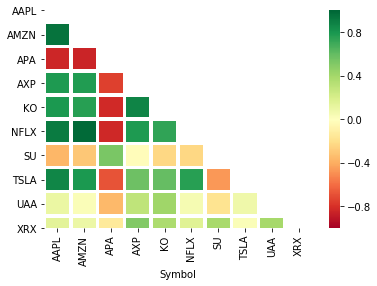

In [6]:
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
#generate plot
sns.heatmap(corr_matrix, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

# Wealth Plot

In [7]:
spy_data = web.DataReader('SPY', 'yahoo', '2010-01-02') # 1) Load web data
brka_data = pd.read_csv("data/BRK-A.csv", parse_dates=True, index_col=0) # 2) Load csv
brka_data.index = pd.to_datetime(brka_data.index, format="%Y-%m-%d")
brka_recent = brka_data["2010":]

spy_data["rets"] = (spy_data["Close"] - spy_data["Open"]) / spy_data["Open"]
brka_recent["rets"] = (brka_recent["Close"] - brka_recent["Open"]) / brka_recent["Open"]


C:\Users\Marcus\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


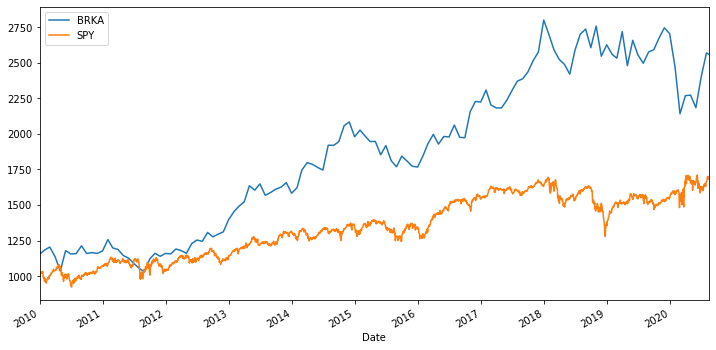

In [8]:
spy_wealth = 1000*(1+spy_data["rets"]).cumprod()
brka_wealth = 1000*(1+brka_recent["rets"]).cumprod()
brka_wealth.plot.line(label="BRKA", legend=True, figsize=(12,6))
spy_wealth.plot.line(label="SPY", legend=True)

In [9]:
import utils as utils
rfr = 1.02**(1/252)-1 # PyPortfolioOpt default rate for consistency
brk_rets = utils.annualize_rets(brka_recent["rets"], 12)
brk_vol = utils.annualize_vol(brka_recent["rets"], 12)
brk_sharpe = utils.sharpe_ratio(brka_recent["rets"],rfr, 12)
print("Berkshire Analysis:")
print("\tExpected annual return: %f\n\tAnnual Volatility: %f\n\tSharpe ratio: %f" % (brk_rets, brk_vol, brk_sharpe))

Berkshire Analysis:
	Expected annual return: 0.091372
	Annual Volatility: 0.157096
	Sharpe ratio: 0.581088


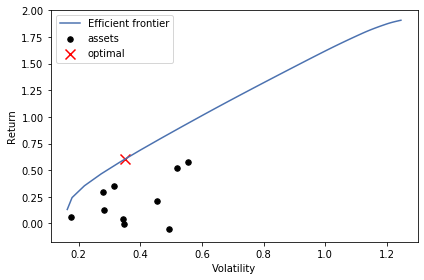

In [10]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt import cla
# Read in price data

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(eq_pivot)
S = risk_models.sample_cov(eq_pivot)

# Optimise for maximal Sharpe ratio
cla = cla.CLA(mu, S, weight_bounds=(-1,1))
plotting.plot_efficient_frontier(cla, points=100, show_assets=True)

In [11]:
weights_df = pd.DataFrame(mu.index)
weights_df["Weights"] = cla.weights
weights_df

,Symbol,Weights
0,AAPL,0.586541
1,AMZN,0.341954
2,APA,-0.170120
3,AXP,0.063377
4,KO,0.123820
5,NFLX,0.223659
6,SU,-0.246972
7,TSLA,0.286397
8,UAA,0.052706
9,XRX,-0.261361


In [12]:
print("EF Portfolio Analysis:")
print("\tExpected annual return: %f\n\tAnnual Volatility: %f\n\tSharpe ratio: %f" % (cla.portfolio_performance()))
print("Berkshire Analysis:")
print("\tExpected annual return: %f\n\tAnnual Volatility: %f\n\tSharpe ratio: %f" % (brk_rets, brk_vol, brk_sharpe))

EF Portfolio Analysis:
	Expected annual return: 0.602191
	Annual Volatility: 0.349120
	Sharpe ratio: 1.667596
Berkshire Analysis:
	Expected annual return: 0.091372
	Annual Volatility: 0.157096
	Sharpe ratio: 0.581088
